In [1]:
#####Hierarchical structured latent factor model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [3]:
####データの発生####
##データの設定
#要素ごとのユニーク数を設定
k = 10
hh = 3000
item = 20000
tag = 300
category = 150
max_m = 20
k_vec = np.repeat(1, k)
m_vec = np.repeat(1, max_m)

#要素ごとの頻度を生成
pt = np.random.poisson(np.random.gamma(25.0, 1/0.2, hh))
N = np.sum(pt)
m = np.random.poisson(5.5, N)
m[m==0] = 1; m[m >= max_m] = max_m
max_m = np.max(m)
M = np.sum(m)

In [4]:
##idとインデックスの設定
#idの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))
m_id = np.repeat(np.arange(N), m)

#インデックスの設定
freq_m = np.repeat(0, hh)
d_index = [i for i in range(hh)]
m_index = [i for i in range(N)]
for i in range(hh):
    d_index[i] = np.array(np.where(d_id==i)[0], dtype="int")
    freq_m[i] = np.sum(m[d_index[i]])
for i in range(N):
    if i==0:
        m_index[i] = np.arange(m[0])
    else:
        m_index[i] = np.max(m_index[i-1]) + np.arange(m[i]) + 1
freq_id = np.repeat(np.arange(hh), freq_m)

In [5]:
##アイテムの生成
#多項分布からトピックを生成
topic = 30
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), hh)
phi_topic = np.random.dirichlet(np.repeat(0.5, item), topic)
z = np.array(rmnom(theta_topic[np.repeat(d_id, m), ], M, topic, np.arange(M), 0), dtype="int")

#トピックからアイテムを生成
item_id = np.repeat(0, M)
item_dt = np.full((N, np.max(m)), item, dtype="int16")
for i in range(N):
    if i%100000==0:
        print(i)
    index = m_index[i]
    target_z = z[index]
    while True:
        temp_id = np.array(rmnom(phi_topic[target_z, ], m[i], item, np.arange(m[i]), 0), dtype="int16")
        if np.unique(temp_id).shape[0]==m[i]:
            item_id[index] = temp_id
            item_dt[i, np.arange(m[i])] = temp_id
            break

0
100000
200000
300000


In [6]:
##アイテムにカテゴリを割り当て
#多項分布からトピックを生成
topic = 20
phi_tag = np.random.dirichlet(np.repeat(0.5, tag), topic)
phi_category = np.random.dirichlet(np.repeat(0.5, category), topic)
z = np.dot(np.random.multinomial(1, np.random.dirichlet(np.repeat(1.0, topic)), item), np.arange(topic))

#トピックからカテゴリを割り当て
tag_id = np.array(rmnom(phi_tag[z, ], item, tag, np.arange(item), 0), dtype="int16")
category_id = np.array(rmnom(phi_category[z, ], item, category, np.arange(item), 0), dtype="int16")

In [7]:
##インデックスを設定
#変数割当のインデックス
allocation_index = [j for j in range(max_m)]
for j in range(max_m):
    allocation_index[j] = np.array(np.where(item_dt[:, j]!=item)[0], dtype="int")

#アイテムのインデックス
item_index = [i for i in range(item)]
item_n = np.repeat(0, item)
for i in range(item):
    item_index[j] = np.array(np.where(np.sum(item_dt==i, axis=1)==1)[0], dtype="int")
    item_n[j] = item_index[j].shape[0]
    
#タグとカテゴリーのインデックス
tag_index = [j for j in range(tag)]
category_index = [j for j in range(category)]
tag_n = np.repeat(0, tag)
category_n = np.repeat(0, category)
for j in range(tag):
    tag_index[j] = np.array(np.where(tag_id==j)[0], dtype="int")
    tag_n[j] = tag_index[j].shape[0]
for j in range(category):
    category_index[j] = np.array(np.where(category_id==j)[0], dtype="int")
    category_n[j] = category_index[j].shape[0]

In [8]:
##応答変数を生成
rp = 0
while True:
    rp = rp + 1
    
    #タグとカテゴリーの階層モデルのパラメータを生成
    alpha_g = np.repeat(0, k)
    alpha_c = np.repeat(0, k)
    tau_g = np.diag(np.repeat(0.2, k))
    tau_c = np.diag(np.repeat(0.2, k))
    alphat_g = alpha_g.copy(); alphat_c = alpha_c.copy()
    taut_g = tau_g.copy(); taut_c = tau_c.copy()

    #ユーザーとアイテムの階層モデルのパラメータを生成
    alpha_u = np.repeat(0, k)
    alpha_v = np.random.normal(0, 0.5, k*k).reshape(k, k)
    theta_g = np.random.multivariate_normal(alpha_g, tau_g, tag)
    theta_c = np.random.multivariate_normal(alpha_c, tau_c, category)
    theta_gc = np.dot(theta_g[tag_id, ] * theta_c[category_id], alpha_v)
    tau_u = np.array([0.4])
    Cov_u = np.diag(np.repeat(0.5, k))
    Cov_v = np.diag(np.repeat(0.2, k))
    alphat_u = alpha_u.copy(); alphat_v = alpha_v.copy(); thetat_g = theta_g.copy(); thetat_c = theta_c.copy()
    taut_u = tau_u.copy(); Covt_u = Cov_u.copy(); Covt_v = Cov_v

    #モデルパラメータを生成
    Sigma = np.array([1.0])
    beta = np.array([-1.0])
    beta_u = np.random.normal(0, tau_u, hh)
    theta_u = np.random.multivariate_normal(alpha_u, Cov_u, hh)
    theta_v = np.zeros((item, k))
    for i in range(item):
        theta_v[i, ] = np.random.multivariate_normal(theta_gc[i, ], Cov_v, 1)

    #モデルの期待値
    theta_item = np.zeros((N, k))
    for j in range(max_m):
        index = allocation_index[j]
        theta_item[index, ] += theta_v[item_dt[index, j], ]
    theta_mu = np.sum(theta_u[d_id, ] * theta_item, axis=1)
    mu = beta + beta_u[d_id] + theta_mu

    #潜在効用から二値変数を生成
    U = np.random.normal(mu, Sigma, N)
    y = np.array(U > 0, dtype="int")

    #break条件
    print([rp, np.round(np.mean(y), 3)])
    if (np.mean(y) >0.2) & (np.mean(y) < 0.4):
        break

[1, 0.356]


(array([1.00000e+00, 2.60000e+01, 1.62000e+02, 2.91900e+03, 8.01000e+04,
        2.75487e+05, 1.59580e+04, 7.68000e+02, 5.40000e+01, 6.00000e+00]),
 array([-23.99099781, -19.4342625 , -14.87752718, -10.32079186,
         -5.76405654,  -1.20732122,   3.3494141 ,   7.90614942,
         12.46288473,  17.01962005,  21.57635537]),
 <a list of 10 Patch objects>)

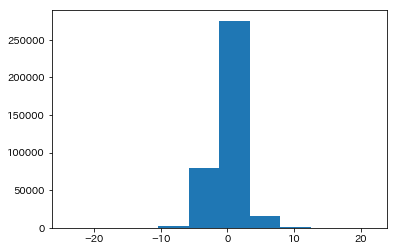

In [113]:
np.sum(theta_mu, axis=1)

array([ 1.43392036, -1.03061066,  0.74397906, ...,  0.64958682,
       -1.89617369, -2.73037774])